In [10]:
import covid19_inference as cov19
import pymc3 as pm
import numpy as np
import pickle

Get parameters for different countries as `countries` dict.

In [11]:
%run change_points.ipynb

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


## Model
### Create model for Austria

In [12]:
key = "Austria"
diff_data_sim = 16
num_days_forecast = 10

#Construct model parameters
params_model = dict(
    new_cases_obs = countries[key]["new_cases"],
    data_begin    = countries["data_begin"],
    fcast_len     = num_days_forecast,
    diff_data_sim = diff_data_sim,
    N_population  = countries[key]["N_population"])


with cov19.Cov19Model(**params_model) as this_model:
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(change_points_list = countries[key]["change_points"],
                                                pr_median_lambda_0 = 0.4) #TODO add to countries dict
        
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    pr_median_delay = 10

    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)

    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.model.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.model.delay_cases(new_I_t,
                                               pr_mean_of_median=pr_median_delay, 
                                               pr_median_of_width=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.model.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases_inferred)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

### MCMC sampling

In [13]:
trace = pm.sample(model=this_model, tune=1000, draws=1000, init='advi+adapt_diag',chains=2)

INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 761.26:  11%|█         | 21799/200000 [01:19<10:46, 275.59it/s]
INFO     [pymc3.variational.inference] Convergence achieved at 21800
INFO     [pymc3.variational.inference] Interrupted at 21,799 [10%]: Average Loss = 775.64
INFO     [pymc3] Multiprocess sampling (2 chains in 4 jobs)
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_6_log_, transient_len_5_log_, transient_len_4_log_, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_6, transient_day_5, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_6_log_, lambda_5_log_, lambda_4_log_, lambda_3_log_, lambda_2

FileNotFoundError: [Errno 2] No such file or directory: './data/austria.pickled'

## Plotting
### English

AssertionError: var should be in trace.varnames

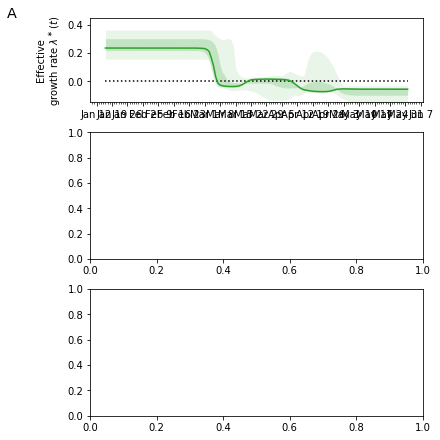

In [15]:
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = True

fig,axes = cov19.plot.timeseries_overview(
    this_model,
    trace,
    offset = countries[key]["total_cases"][0])

### German